<a href="https://colab.research.google.com/github/5234560002ebnida/nonfictioner/blob/main/vwap_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


              Close          VWAP    Upper Band    Lower Band  Buy Signal  \
Date                                                                        
2012-05-21  53600.0  54000.000000           NaN           NaN           0   
2012-05-22  54800.0  54274.685291           NaN           NaN           0   
2012-05-23  53800.0  54192.414378           NaN           NaN           0   
2012-05-24  53700.0  54118.070518           NaN           NaN           0   
2012-05-25  55100.0  54236.804291           NaN           NaN           0   
...             ...           ...           ...           ...         ...   
2024-07-22  48000.0  49766.731090  50785.997252  48747.464928           0   
2024-07-23  47350.0  49766.363565  50793.971857  48738.755273           0   
2024-07-24  46250.0  49765.550798  50742.357865  48788.743731           0   
2024-07-25  46500.0  49764.855547  50695.853565  48833.857529           0   
2024-07-26  47450.0  49764.423897  50691.253919  48837.593875           0   

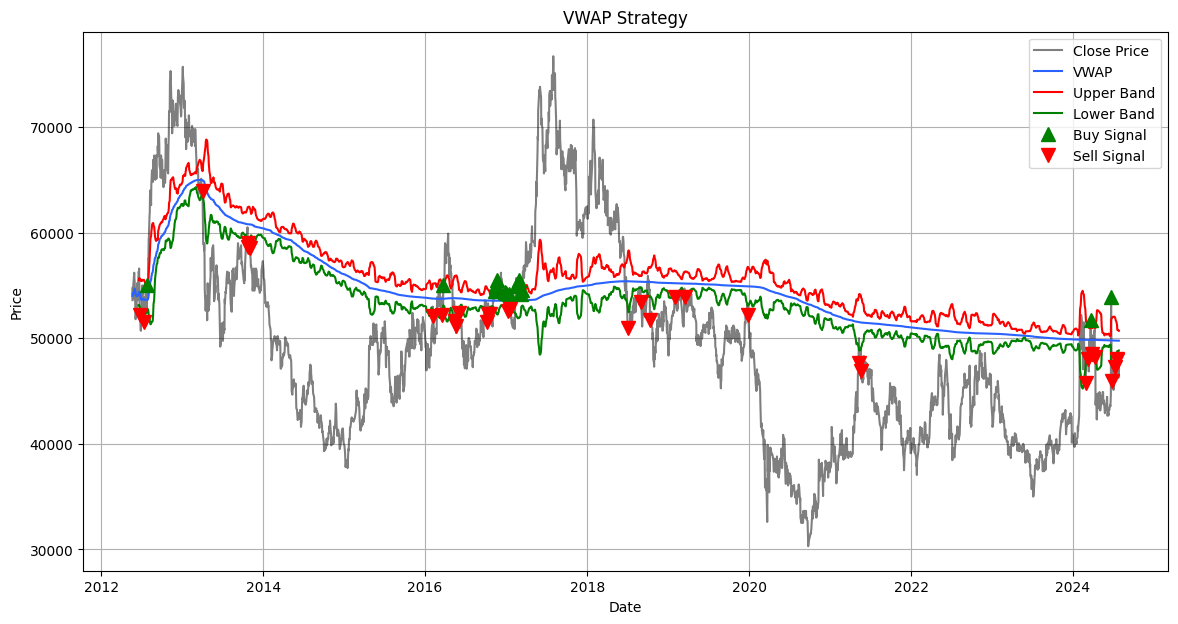

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

def get_price(symbol, startTime, endTime, timeframe='day'):
    count = 3000
    url = f"https://fchart.stock.naver.com/sise.nhn?symbol={symbol}&timeframe={timeframe}&count={count}&requestType=0"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = []
    items = soup.select('item')
    for item in items:
        row = item['data'].split('|')
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df.astype(float)

def calculate_vwap(data, length=20):
    data['TP'] = (data['Close'] + data['High'] + data['Low']) / 3
    data['Cumulative_TP_Volume'] = (data['TP'] * data['Volume']).cumsum()
    data['Cumulative_Volume'] = data['Volume'].cumsum()
    data['VWAP'] = data['Cumulative_TP_Volume'] / data['Cumulative_Volume']

    std = data['TP'].rolling(length).std()
    data['Upper Band'] = data['VWAP'] + std
    data['Lower Band'] = data['VWAP'] - std

    return data

def generate_signals(data):
    # 매수 및 매도 신호 생성: 주가가 Upper Band를 돌파하면 매수, Lower Band를 이탈하면 매도
    data['Buy Signal'] = np.where((data['Close'] > data['Upper Band']) & (data['Close'].shift(1) <= data['Upper Band'].shift(1)), 1, 0)
    data['Sell Signal'] = np.where((data['Close'] < data['Lower Band']) & (data['Close'].shift(1) >= data['Lower Band'].shift(1)), 1, 0)
    return data

def plot_vwap_strategy(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price', color='black', alpha=0.5)
    plt.plot(data.index, data['VWAP'], label='VWAP', color='#2962FF')
    plt.plot(data.index, data['Upper Band'], label='Upper Band', color='red')
    plt.plot(data.index, data['Lower Band'], label='Lower Band', color='green')

    buy_signals = data[data['Buy Signal'] == 1]
    sell_signals = data[data['Sell Signal'] == 1]
    plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='green', lw=0, label='Buy Signal')
    plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='red', lw=0, label='Sell Signal')

    plt.title('VWAP Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 사용 예시
symbol = '078930'  # GS종목코드
startTime = '20220501'
endTime = '20220518'

df = get_price(symbol, startTime, endTime, 'day')
df = calculate_vwap(df)
df = generate_signals(df)

print(df[['Close', 'VWAP', 'Upper Band', 'Lower Band', 'Buy Signal', 'Sell Signal']])
plot_vwap_strategy(df)

